In [2]:
import scipy
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [3]:
dataset_train = loadmat('train_spanish_2022_python.mat')
dataset_validation = loadmat('validation_spanish_2022_python.mat')

In [4]:
dataset_train.keys()

dict_keys(['__header__', '__version__', '__globals__', 'features_train', 'labels_train_int'])

In [5]:
dataset_train['labels_train_int'].shape

(11554, 1)

In [6]:
Xtrain = dataset_train['features_train']
Ytrain = dataset_train['labels_train_int'].flatten()

In [7]:
dataset_validation.keys()

dict_keys(['__header__', '__version__', '__globals__', 'features_validation', 'labels_validation_int'])

In [8]:
Xval = dataset_validation['features_validation']
Yval = dataset_validation['labels_validation_int'].flatten()

# Normalizacion

In [9]:
m = Xtrain.mean(axis=0, keepdims=True)
s = Xtrain.std(axis=0, keepdims=True)

Xtrain_norm = (Xtrain - m) / s
Xval_norm = (Xval - m) / s

In [10]:
m.shape

(1, 85)

# Create dataset

In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader


# Convert lists to tensors
Xtrain_tensor = torch.tensor(Xtrain_norm, dtype=torch.float32)
Ytrain_tensor = torch.tensor(Ytrain, dtype=torch.long)

Xval_tensor = torch.tensor(Xval_norm, dtype=torch.float32)
Yval_tensor = torch.tensor(Yval, dtype=torch.long)

# Create TensorDataset
train_dataset = TensorDataset(Xtrain_tensor, Ytrain_tensor)
val_dataset = TensorDataset(Xval_tensor, Yval_tensor)
# Create DataLoader

# Primera red

In [12]:
import torch
from torch import nn

In [13]:
class Red(nn.Sequential):
    def __init__(self, input_dim=85, hidden_dim=[4,], out_dim=10, dropout=0.0):
        assert len(hidden_dim) > 0, "at least one hidden layer"
        layers = []
        # first layer
        layers.append(nn.Linear(input_dim, hidden_dim[0]))
        layers.append(nn.BatchNorm1d(hidden_dim[0]))
        if dropout > 0.0:
            layers.append(nn.Dropout(dropout))
        layers.append(nn.ReLU(inplace=True))

        if len(hidden_dim) > 1:
            for k in range(1, len(hidden_dim)):
                layers.append(nn.Linear(hidden_dim[k-1], hidden_dim[k]))
                layers.append(nn.BatchNorm1d(hidden_dim[k]))
                layers.append(nn.Dropout(dropout))
                layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(hidden_dim[-1], out_dim))
        super().__init__(*layers)

# Training loop

In [14]:
def train_epoch(network, loss_fn, dataloader, optimizer, device='cpu'):
    # Set the network to train mode
    network.to(device)
    network.train()

    # Initialize variables to keep track of loss and number of batches
    epoch_loss = 0.0
    num_batches = 0
    epoch_correct = 0.0
    num_samples = 0

    # Iterate over the data loader
    for batch_inputs, batch_targets in dataloader:
        # Move data to the appropriate device (e.g., GPU)
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        batch_outputs = network(batch_inputs)

        # Compute the loss
        loss = loss_fn(batch_outputs, batch_targets)

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Accumulate the loss
        epoch_loss += loss.item()
        num_batches += 1

       # Calculate the number of correct predictions in the batch
        _, predicted = torch.max(batch_outputs, 1)
        epoch_correct += (predicted == batch_targets).sum().item()
        num_samples += batch_targets.size(0)

    # Calculate the average loss for the epoch
    average_loss = epoch_loss / num_batches

    # Calculate the accuracy for the epoch
    accuracy = epoch_correct / num_samples

    return average_loss, accuracy

In [15]:
def validate_epoch(network, loss_fn, dataloader, device='cpu'):
    # Set the network to evaluation mode
    network.to(device)
    network.eval()

    # Initialize variables to keep track of loss and number of batches
    epoch_loss = 0.0
    num_batches = 0
    epoch_correct = 0.0
    num_samples = 0

    # Turn off gradients
    with torch.no_grad():
        # Iterate over the data loader
        for batch_inputs, batch_targets in dataloader:
            # Move data to the appropriate device (e.g., GPU)
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)

            # Forward pass
            batch_outputs = network(batch_inputs)

            # Compute the loss
            loss = loss_fn(batch_outputs, batch_targets)

            # Accumulate the loss
            epoch_loss += loss.item()
            num_batches += 1

            # Calculate the number of correct predictions in the batch
            _, predicted = torch.max(batch_outputs, 1)
            epoch_correct += (predicted == batch_targets).sum().item()
            num_samples += batch_targets.size(0)

    # Calculate the average loss for the epoch
    average_loss = epoch_loss / num_batches

    # Calculate the accuracy for the epoch
    accuracy = epoch_correct / num_samples

    return average_loss, accuracy

In [16]:
from tqdm import tqdm


def train(network, loss_fn, train_dataloader, val_dataloader, optimizer, num_epochs, device='cpu'):
    train_losses = []
    val_losses = []
    val_acc = []
    train_acc = []

    best_val_acc = 0.0
    best_epoch = -1

    # Initialize tqdm for progress tracking
    progress_bar = tqdm(range(num_epochs), desc='Training Progress')

    for epoch in progress_bar:
        # Training phase
        train_loss, train_accuracy = train_epoch(
            network, loss_fn, train_dataloader, optimizer, device=device)
        train_losses.append(train_loss)
        train_acc.append(train_accuracy)
        # Validation phase
        val_loss, val_accuracy = validate_epoch(
            network, loss_fn, val_dataloader, device=device)
        val_losses.append(val_loss)
        val_acc.append(val_accuracy)

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_epoch = epoch
            print(f"Best val acc {best_val_acc:.3f} at epoch {epoch}")
        # Print the loss for each epoch
        # print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f},Val Loss: {val_loss:.4f} Val Acc: {accuracy:.4f}')

        # Update tqdm progress bar
        progress_bar.set_postfix({'Train Loss': train_loss, 'Val Loss': val_loss,
                                 'Train Acc': train_accuracy, 'Val Acc': val_accuracy})
    return train_losses, val_losses, train_acc, val_acc

In [17]:
import torch.optim as optim

# Assuming you have already defined your neural network model and loss function
# network = YourNeuralNetwork()
# loss_fn = YourLossFunction()

# Define learning rate
learning_rate = 0.01
batch_size = 1024

# Define network
red1 = Red(hidden_dim=[4], dropout=0.25)

# Create Adam optimizer
# optimizer = optim.SGD(red1.parameters(), lr=learning_rate, momentum =0.9)
optimizer = optim.Adam(red1.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()


num_epochs = 150
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


train_losses, val_losses, train_acc, val_acc = train(
    red1, loss_fn, train_dataloader, val_dataloader, optimizer, num_epochs, device='cpu')

Training Progress:   1%|▏         | 2/150 [00:00<00:13, 11.02it/s, Train Loss=1.7, Val Loss=1.52, Train Acc=0.369, Val Acc=0.501] 

Best val acc 0.277 at epoch 0
Best val acc 0.377 at epoch 1
Best val acc 0.421 at epoch 2
Best val acc 0.501 at epoch 3


Training Progress:   5%|▌         | 8/150 [00:00<00:08, 17.05it/s, Train Loss=1.42, Val Loss=1.17, Train Acc=0.487, Val Acc=0.628]

Best val acc 0.563 at epoch 4
Best val acc 0.604 at epoch 5
Best val acc 0.639 at epoch 6


Training Progress:   7%|▋         | 11/150 [00:00<00:07, 19.13it/s, Train Loss=1.33, Val Loss=1.09, Train Acc=0.5, Val Acc=0.649] 

Best val acc 0.646 at epoch 8
Best val acc 0.654 at epoch 9
Best val acc 0.661 at epoch 11


Training Progress:  11%|█▏        | 17/150 [00:00<00:06, 19.95it/s, Train Loss=1.3, Val Loss=1.04, Train Acc=0.524, Val Acc=0.65]  

Best val acc 0.670 at epoch 14


Training Progress:  19%|█▉        | 29/150 [00:01<00:05, 20.32it/s, Train Loss=1.27, Val Loss=0.998, Train Acc=0.539, Val Acc=0.662]

Best val acc 0.672 at epoch 24


Training Progress:  21%|██▏       | 32/150 [00:01<00:06, 18.85it/s, Train Loss=1.25, Val Loss=0.978, Train Acc=0.545, Val Acc=0.676]

Best val acc 0.680 at epoch 29


Training Progress:  25%|██▌       | 38/150 [00:02<00:05, 19.28it/s, Train Loss=1.25, Val Loss=0.969, Train Acc=0.538, Val Acc=0.68] 

Best val acc 0.683 at epoch 34


Training Progress:  27%|██▋       | 41/150 [00:02<00:05, 20.22it/s, Train Loss=1.26, Val Loss=0.962, Train Acc=0.54, Val Acc=0.685] 

Best val acc 0.685 at epoch 38
Best val acc 0.689 at epoch 39


Training Progress:  33%|███▎      | 50/150 [00:02<00:05, 19.68it/s, Train Loss=1.25, Val Loss=0.946, Train Acc=0.553, Val Acc=0.717]

Best val acc 0.705 at epoch 47
Best val acc 0.713 at epoch 48
Best val acc 0.713 at epoch 49
Best val acc 0.717 at epoch 50


Training Progress:  37%|███▋      | 56/150 [00:02<00:04, 19.56it/s, Train Loss=1.24, Val Loss=0.93, Train Acc=0.557, Val Acc=0.715] 

Best val acc 0.721 at epoch 52


Training Progress:  39%|███▉      | 59/150 [00:03<00:04, 20.45it/s, Train Loss=1.24, Val Loss=0.96, Train Acc=0.553, Val Acc=0.726] 

Best val acc 0.723 at epoch 56
Best val acc 0.724 at epoch 57
Best val acc 0.726 at epoch 58
Best val acc 0.726 at epoch 59


Training Progress:  45%|████▌     | 68/150 [00:03<00:04, 19.82it/s, Train Loss=1.25, Val Loss=0.914, Train Acc=0.557, Val Acc=0.726]

Best val acc 0.729 at epoch 65


Training Progress:  53%|█████▎    | 80/150 [00:04<00:03, 19.94it/s, Train Loss=1.23, Val Loss=0.92, Train Acc=0.557, Val Acc=0.721] 

Best val acc 0.732 at epoch 76


Training Progress:  61%|██████▏   | 92/150 [00:04<00:02, 20.19it/s, Train Loss=1.24, Val Loss=0.926, Train Acc=0.552, Val Acc=0.729]

Best val acc 0.735 at epoch 88


Training Progress: 100%|██████████| 150/150 [00:07<00:00, 19.90it/s, Train Loss=1.22, Val Loss=0.918, Train Acc=0.562, Val Acc=0.728]


Text(0, 0.5, 'Loss')

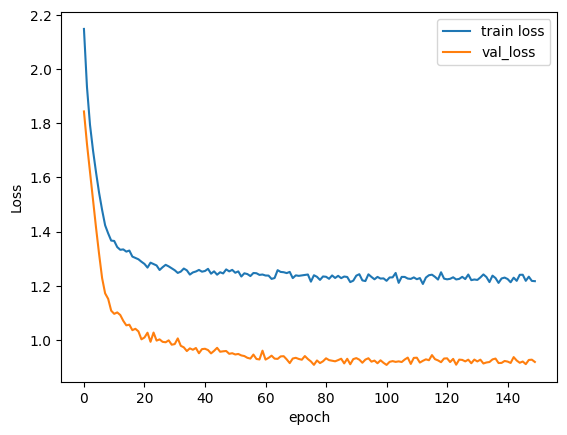

In [18]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

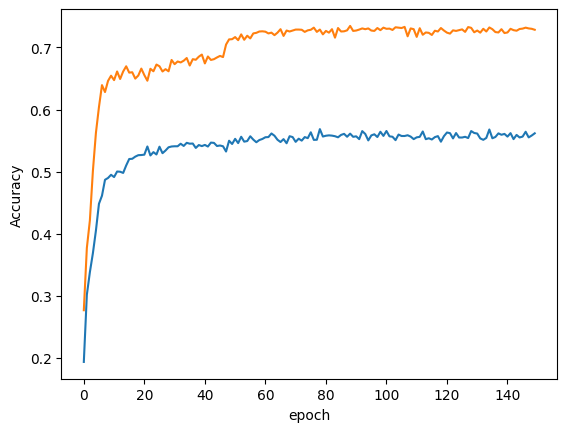

In [19]:
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc, label='val acc')
plt.xlabel('epoch')
plt.ylabel('Accuracy')